This notebook is based on the TT-cross algorithm proposed in the following paper:
 \\
Oseledets I, Tyrtyshnikov E. TT-cross approximation for multidimensional arrays. Linear Algebra and its Applications. 2010 Jan 1;432(1):70-88.

In [ ]:
import os
os.environ["JAX_ENABLE_X64"] = "True"

import jax.numpy as jnp
import numpy as np
from jax import random
import matplotlib.pyplot as plt

key = random.PRNGKey(42)

!git clone 'https://github.com/LuchnikovI/TT-cross-implementation-on-jax'
%cd 'TT-cross-implementation-on-jax'

# The tools for TT-cross based reconstruction and some operations with TT format
from tt import TT_cross, eval, compression, relative_difference_sq, dot

As the first example we consider TT-based reconstruction of a simple tensor that is defined by the following identity
$$T_{j_1, j_2, \dots j_N} = i\sin\left(j_1 + j_2 + \dots + j_N\right) + \exp\left(\frac{1}{N}\left(j_1 + j_2 + \dots + j_N\right)\right).$$ This tensor has TT-rank equal to $3$ and is an ''easy'' case for the TT-cross based reconstruction. We define this tensor through the function below that is used as a ''black box'' in the TT-cross algorithm.

In [2]:
# We assume the following shape of the tensor
shape = 20 * (5,)

# The function that defines the tensor
def f(x):
    """The function returns values of the tensor given the set of indices.

    Args:
        x: int array of shape (number_of_indices, N).

    Returns:
        complex valued tensor of shape (number_of_indices,)
        filled by the values of the tensor."""

    return 1j*jnp.sin(x.sum(-1)) + jnp.exp(x.mean(-1))

Next, we apply the TT-cross algorithm to this function in order to reconstruct the TT format of a tensor from a few evaluations of this function.

In [3]:
# ========== Parameters ============ #
eps = 1e-10  # rounding accuracy
max_r = 10  # max. TT rank used for TT-cross based reconstruction
number_of_sweeps = 3  # number of DMRG sweeps used for TT-cross based reconstruction

# define TT-cross object
key, subkey = random.split(key)
tt_cross = TT_cross(subkey, max_r, shape)

# perform DMRG sweeps
while tt_cross.current_sweep < number_of_sweeps:
    # current arguments (indices) that are need to be evaluated
    args = tt_cross.get_arg()
    # function evaluation
    measurements = f(args)
    # update of TT decomposition
    tt_cross.update(measurements)
# get reconstructed TT kernels
cross_kernels = tt_cross.get_tt_kernels()
# compression of the reconstructed TT representation
cross_kernels = compression(cross_kernels, eps)

Now we can test how accurate the reconstructed representation is. For this purpose, we sample at random 10 arguments and evaluate the exact tensor and the reconstructed one for these 10 arguments.

In [5]:
indices = tt_cross.random_args(key, 10)
print('Randomly sampled exact values = \n{}\n'.format(f(indices).round(10)))
print('Randomly sampled cross. approx. values = \n{}\n'.format(eval(cross_kernels, indices).round(10)))

Randomly sampled exact values = 
[54.59815003-0.99388865j 20.08553692-0.30481062j  2.71828183+0.91294525j
 20.08553692-0.30481062j  1.        +0.j          2.71828183+0.91294525j
 54.59815003-0.99388865j  2.71828183+0.91294525j  2.71828183+0.91294525j
  1.        +0.j        ]

Randomly sampled cross. approx. values = 
[54.59815003-0.99388865j 20.08553692-0.30481062j  2.71828183+0.91294525j
 20.08553692-0.30481062j  1.        +0.j          2.71828183+0.91294525j
 54.59815003-0.99388865j  2.71828183+0.91294525j  2.71828183+0.91294525j
  1.        +0.j        ]



We also can check whether the TT-cross algorithm recognized the genuine TT-rank of the tensor that is equal to $3$. For this purpose, we plot the bond dimensions of all kernels below.

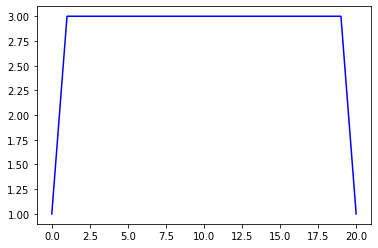

In [6]:
plt.plot([cross_kernels[0].shape[0]] + [ker.shape[2] for ker in cross_kernels], 'b')

As the second example, we consider TT-cross based reconstruction of a randomly generated tensor in the TT format. Real and imaginary parts of all kernels of the TT format are sampled from the i.i.d. Normal distribution with unit std, i.e. $N(0, 1)$. Shape of a tensor $(d_1, d_2, \dots, d_N)$, where $N$ is the rank of tensor, is also sampled randomly; each $d_i$ takes values from the set $\{2,\dots,n\}$ equiprobably. Bond dimensions $(b_{1,2}, b_{2,3}, \dots, b_{N-1,N})$ are also sampled equiprobably from the set $\{2,\dots,m\}$.
 \\
In the cell below, we generate kernels as it is described here.

In [7]:
# ======= Parameters of the TT decomposition ======= #
N = 20
n = 12
m = 15
# ================================================== #

# ============= Below we randomly generate shape ============== #
shape = np.random.randint(2, n+1, (N,))

# ============= Below we randomly generate bond dimensions ============= #
bonds_between_kers = np.random.randint(2, m+1, (N-1,))
left_bonds = np.concatenate([np.ones((1,), dtype=np.int64), bonds_between_kers])
right_bonds = np.concatenate([bonds_between_kers, np.ones((1,), dtype=np.int64)])

# ============= Below we randomly generate kernels of the TT format ============= #

shapes = zip(left_bonds, shape, right_bonds)  # iterator over kernels' shapes

# function that generates a random kernel from its shape
def random_ker(shape):
    ker = np.random.normal(size = (*shape, 2))
    ker /= np.sqrt(2 * shape[0])
    ker = ker[..., 0] + 1j * ker[..., 1]
    return ker

# random TT kernels in a list
exact_kernels = [random_ker(shape) for shape in shapes]

print('The shape of a tensor is {} \n'.format(shape))

The shape of a tensor is [10  2  9  5  9 11  7  8  4  7  4  3 11  8  2  2  9 10  6  4] 



TT-cross algorithm requires access to any element of a tensor. For this purpose, we define a function that returns values of a tensor given the set of indices.

In [8]:
def f(x):
    """The function returns values of the tensor given the set of indices.

    Args:
        x: int array os shape (number_of_indices, N).

    Returns:
        complex valued tensor of shape (number_of_indices,)
        filled by the values of the tensor."""

    return eval(exact_kernels, x)

Next, we apply the TT-cross algorithm to this function in order to reconstruct the TT format of a tensor from a few evaluations of this function.

In [9]:
# ========== Parameters ============ #
eps = 1e-10  # rounding accuracy
max_r = 20  # max. TT rank used for TT-cross based reconstruction
number_of_sweeps = 3  # number of DMRG sweeps used for TT-cross based reconstruction

# define TT-cross object
key, subkey = random.split(key)
tt_cross = TT_cross(subkey, max_r, shape)

# perform DMRG sweeps
while tt_cross.current_sweep < number_of_sweeps:
    # current arguments (indices) that are need to be evaluated
    args = tt_cross.get_arg()
    # function evaluation
    measurements = f(args)
    # update of TT decomposition
    tt_cross.update(measurements)
# get reconstructed TT kernels
cross_kernels = tt_cross.get_tt_kernels()
# compression of the reconstructed TT representation
cross_kernels = compression(cross_kernels, eps)

Now we can test how accurate the reconstructed representation is.
For this purpose, we sample at random 10 arguments and evaluate the exact tensor and the reconstructed one for these 10 arguments. Then we also calculate the square relative difference between tensors, i.e.
$$\frac{\|T_{\rm exact} - T_{\rm reconstructed}\|_F^2}{\|T_{\rm exact}\|^2_F}.$$

In [10]:
indices = tt_cross.random_args(key, 10)
print('Randomly sampled exact values = \n{}\n'.format(eval(exact_kernels, indices)))
print('Randomly sampled cross. approx. values = \n{}\n'.format(eval(cross_kernels, indices)))
print('Relative difference between tensors = {}'.format(relative_difference_sq(cross_kernels, exact_kernels)))

Randomly sampled exact values = 
[ 0.05149488-0.03289361j  0.19137162-0.43431929j -0.4385241 -0.82627933j
  0.18752862+0.56106448j  0.94690871-0.02855655j  0.25690723+0.99191005j
 -0.07547387-1.24845658j -0.02874753+0.15376566j  0.27653343-0.419711j
  0.11229823+0.30159793j]

Randomly sampled cross. approx. values = 
[ 0.05149488-0.03289361j  0.19137162-0.43431929j -0.4385241 -0.82627933j
  0.18752862+0.56106448j  0.94690871-0.02855655j  0.25690723+0.99191005j
 -0.07547387-1.24845658j -0.02874753+0.15376566j  0.27653343-0.419711j
  0.11229823+0.30159793j]

Relative difference between tensors = 1.4210854715202004e-14


We also compare bond dimensions of the exact TT format and the reconstructed one.

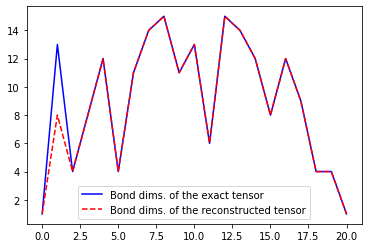

In [11]:
plt.plot([exact_kernels[0].shape[0]] + [ker.shape[2] for ker in exact_kernels], 'b')
plt.plot([cross_kernels[0].shape[0]] + [ker.shape[2] for ker in cross_kernels], 'r--')
plt.legend(['Bond dims. of the exact tensor', 'Bond dims. of the reconstructed tensor'])